In [1]:
from fastfusion import arch
from fastfusion import constraints
from fastfusion import workload
import fastfusion

variables = {"tech_node": 1e-9}
global_cycle_period = 1e-9

main_memory = arch.Memory(
    name="MainMemory",
    component_class="DRAM",
    attributes=dict(
        _size=4*1024*1024*1024*8,
        _bandwidth_reads_plus_writes_per_cycle=614e9 / 8192 * global_cycle_period,
        _datawidth=8,
        width=8192,
        depth=4*1024*1024*1024*8 / 8192,
    ))
main_memory.constraints.tensors.keep = "~Intermediates()"

global_buffer = arch.Memory(
    name="GlobalBuffer",
    component_class="SRAM",
    attributes=dict(
        _size=1024*1024*128*8,
        _datawidth=8,
        _bandwidth_reads_plus_writes_per_cycle=1,
        width=16384,
        depth=1024*1024*128*8 / 16384,
    )
)
global_buffer.constraints.tensors.keep = "All()"
global_buffer.constraints.tensors.no_refetch_from_above = "All() if ~MainMemory.tensors() else Nothing()"
global_buffer.constraints.dataflow.tensor_order_options = [["MainMemory.tensors()", "~MainMemory.tensors()"]]

local_buffer = arch.Memory(
    name="LocalBuffer",
    component_class="SRAM",
    attributes=dict(
        _size=1024*1024*4*8,
        _datawidth=8,
        _bandwidth_reads_plus_writes_per_cycle=1,
        width=16384,
        depth=1024*1024*4*8 / 16384,
    ),
    spatial=[{"name": "Z", "fanout": 4}],
)
local_buffer.constraints.tensors.keep = "input | output"

local_buffer.constraints.dataflow.tensor_order_options = [["output", "input"]]
local_buffer.constraints.spatial.append(constraints.Spatial(
    name="Z",
    min_utilization="1 if len(All()) > 2 else 0",
    loop_bounds=[{"expression": "weight.rank_variables()", "operator": "==", "value": 1}]
))

register = arch.Memory(
    name="Register",
    component_class="dummy_storage",
    spatial=[{"name": "X", "fanout": 128}, {"name": "Y", "fanout": 128}],
    attributes=dict(
        _size=8,
        _datawidth=8,
    )
)
register.constraints.tensors.keep = "weight"
register.constraints.tensors.bypass = "~weight"
register.constraints.spatial.append(constraints.Spatial(
    name="X",
    min_utilization=1,
    loop_bounds=[{"expression": "input.rank_variables()", "operator": "==", "value": 1}]
))
register.constraints.spatial.append(constraints.Spatial(
    name="Y",
    min_utilization=1,
    loop_bounds=[{"expression": "output.rank_variables()", "operator": "==", "value": 1}]
))

compute = arch.Compute(
    name="MAC",
    component_class="intmac",
    attributes=dict(
        multiplier_width=8,
        adder_width=16,
    )
)
compute.constraints.misc.enabled = "len(All()) == 3"

scalar_unit = arch.Compute(
    name="scalar_unit",
    component_class="dummy_compute",
    attributes=dict(
        area=1,
        _computes_per_cycle=128
    )
)
scalar_unit.constraints.misc.enabled = "len(All()) == 2"


arch = arch.Arch(
    nodes=[
        main_memory,
        global_buffer,
        local_buffer,
        scalar_unit,
        register,
        compute,
    ],
    global_cycle_period=global_cycle_period,
)




acc0 = workload.TensorAccess(name="T0", projection=["m", "n0"])
acc1 = workload.TensorAccess(name="W0", projection=["n0", "n1"])
acc2 = workload.TensorAccess(name="T1", projection=["m", "n1"], output=True)
renames = {"input": "T0", "weight": "W0", "output": "T1"}
matmul1 = workload.Einsum(name="Matmul1", tensor_accesses=[acc0, acc1, acc2], renames=renames)

workload = workload.Workload(
    einsums=[matmul1],
    shape=dict(
        m="0 <= m < 128",
        n0="0 <= n0 < 64",
        n1="0 <= n1 < 128",
    ),
)

spec = fastfusion.Specification(
    arch=arch,
    workload=workload,
    variables=variables,
)
pmappings = fastfusion.mapper.FFM.make_pmappings(spec)

WARNING Loading configuration file from /root/.config/fastfusion/config.yaml
Generating pmapping templates for compute scalar_unit Einsum Matmul1: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum Matmul1: 18it [00:00, 63.39it/s]
Generating jobs: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
WARNING Einsum Matmul1 has 18 pmapping templates:
WARNING 	[W0,T1,T0 in MainMemory] T-m,n0 [T0 in GlobalBuffer] T-n1 [T1 in GlobalBuffer] T-n0 [W0 in GlobalBuffer] S-Z-m T-m [T1 in LocalBuffer] T-n0 [T0 in LocalBuffer] S-Y-n0 S-X-n1 T-n1 [W0 in Register] T-m MAC computes Matmul1
WARNING 	[W0,T1,T0 in MainMemory] T-m,n0 [T0 in GlobalBuffer] T-n1 [W0 in GlobalBuffer] T-m [T1 in GlobalBuffer] S-Z-m [T1 in LocalBuffer] T-n0 [T0 in LocalBuffer] S-Y-n0 S-X-n1 T-n1 [W0 in Register] T-m MAC computes Matmul1
WARNING 	[W0,T1,T0 in MainMemory] T-m,n1 [T1 in GlobalBuffer] T-n0 [T0 in GlobalBuffer] T-n1 [W0 in GlobalBuffer] S-Z-m T-m [T1 in LocalBuffer] T-n0 [T0 in LocalBuffer] S-Y-n0 S-X-

In [41]:
import fastfusion
from fastfusion.mapper import Metrics

spec = fastfusion.Specification.from_yaml(
    "architectures/fastfusion/tpu_like.yaml",
    "workloads/fastfusion/gemm_16k.yaml",
)
spec.mapper.ffm.metrics = Metrics.ENERGY | Metrics.LATENCY
pmappings = fastfusion.mapper.FFM.make_pmappings(spec)
mappings = fastfusion.mapper.FFM.join_pmappings(spec, pmappings)

2025-09-24 13:49:42,426 - from_yaml +420 - INFO - Loading yaml file architectures/fastfusion/tpu_like.yaml
2025-09-24 13:49:42,469 - from_yaml +431 - INFO - Found top key arch in architectures/fastfusion/tpu_like.yaml
2025-09-24 13:49:42,470 - from_yaml +420 - INFO - Loading yaml file workloads/fastfusion/gemm_16k.yaml
2025-09-24 13:49:42,486 - from_yaml +431 - INFO - Found top key renames in workloads/fastfusion/gemm_16k.yaml
2025-09-24 13:49:42,487 - from_yaml +431 - INFO - Found top key workload in workloads/fastfusion/gemm_16k.yaml
2025-09-24 13:49:42,490 - get_config +31 - WARNING - Loading configuration file from /home/gilbertm/work/infrastructure/venv/fastfusion/config.yaml

Generating pmapping templates for compute scalar_unit Einsum Matmul: 0it [00:00, ?it/s][00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum Matmul: 8it [00:00, 51.75it/s]01<00:01,  1.33s/it]

Generating jobs: 100%|███████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.16i

Einsum Matmul has 8 pmappings with 8 compatibilities



Compressing pmappings: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 64.82it/s]


Not tracking GlobalBuffer because it is never reserved for multiple pmappings.
Not tracking LocalBuffer because it is never reserved for multiple pmappings.
Not tracking MainMemory because it is never reserved for multiple pmappings.
Not tracking Register because it is never reserved for multiple pmappings.



Removing unneeded reservations for Matmul: 100%|███████████████████████| 16/16 [00:01<00:00,  8.97it/s]
2025-09-24 13:49:52,488 - print_time +32 - INFO - Initial consolidate and group: 0.01 seconds

Final consolidate: 100%|██████████████████████████████████████████████| 16/16 [00:00<00:00, 689.92it/s]

Grouping pmappings: 100%|███████████████████████████████████████████████| 1/1 [00:00<00:00, 245.45it/s]
2025-09-24 13:49:52,526 - print_total_time +38 - INFO - 
======== Total time ========
2025-09-24 13:49:52,526 - print_total_time +40 - INFO - Initial consolidate and group: 0.01 seconds
2025-09-24 13:49:52,528 - print_total_time +45 - INFO - 
Total: 0.01 seconds
2025-09-24 13:49:52,529 - print_total_time +46 - INFO - ============================



In [44]:
mappings.data

,Total<SEP>latency,Total<SEP>energy,Matmul<SEP>stride0,Matmul<SEP>stride1,Matmul<SEP>stride2,Matmul<SEP>stride3,Matmul<SEP>stride4,Matmul<SEP>latency<SEP>compute,Matmul<SEP>latency<SEP>Register,Matmul<SEP>latency<SEP>GlobalBuffer,...,Matmul<SEP>energy<SEP>MainMemory<SEP>write,Matmul<SEP>energy<SEP>MAC<SEP>compute,Matmul<SEP>energy<SEP>MainMemory<SEP>leak,Matmul<SEP>energy<SEP>GlobalBuffer<SEP>leak,Matmul<SEP>energy<SEP>LocalBuffer<SEP>leak,Matmul<SEP>energy<SEP>scalar_unit<SEP>leak,Matmul<SEP>energy<SEP>Register<SEP>leak,Matmul<SEP>energy<SEP>MAC<SEP>leak,Matmul<SEP>mapping,Total<SEP>mapping
7,0.411042,0.620749,512,1024,128,128,128,0.067109,0,0,...,0.001887,0.307863,0,0,0,0,0,0,"type=None nodes=[Storage(type=None, tensors=['...",<fastfusion.mapper.FFM._interface.main.Mapping...


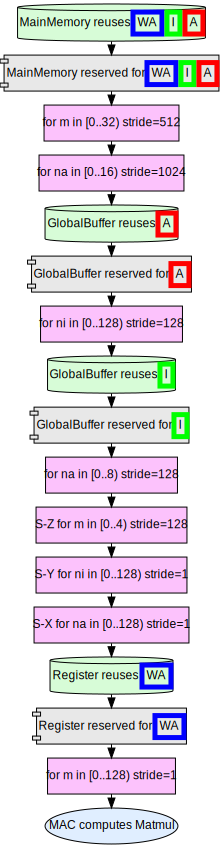

In [43]:
from IPython.display import SVG, display

display(SVG(mappings.data.iloc[0]['Total<SEP>mapping'].render()))

In [39]:
"""
The following code is adapted from main.py in the ZigZag repository.

To run the code, first install ZigZag with `pip3 install zigzag-dse`.
"""
from datetime import datetime
import time

from zigzag import api

workload_path = "workloads/zigzag/gemm_16k.yaml"
accelerator_path = "architectures/zigzag/tpu_like.yaml"
mapping_path = "mapping/zigzag/tpu_custom.yaml"
experiment_id = datetime.now()
dump_folder = f"outputs/zigzag/{experiment_id}"
pickle_filename = f"outputs/zigzag/{experiment_id}/cmes.pickle"


for lpf_limit in range(3, 9):
    start = time.time()
    energy, latency, cmes = api.get_hardware_performance_zigzag(
        workload=workload_path,
        accelerator=accelerator_path,
        mapping=mapping_path,
        opt="energy",
        dump_folder=dump_folder,
        pickle_filename=pickle_filename,
        lpf_limit=lpf_limit
    )
    end = time.time()
    duration = end - start
    print(f"lpf = {lpf_limit}")
    print(f"Time = {duration:.2e} s")
    print(f"Total energy = {energy:.2e} pJ")
    print(f"Total latency = {latency:.2e} cycles")

2025-09-24 13:45:36,809 - run +49 - INFO - Processing  Layer0...
2025-09-24 13:45:36,813 - run +93 - INFO - Layer0: Launching spatial mapping 1/3: {D1: {C: 128}, D2: {K: 128}, D0: {D: 4}}.
100%|████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 98.64it/s]
2025-09-24 13:45:36,883 - run +93 - INFO - Layer0: Launching spatial mapping 2/3: {D1: {C: 128}, D2: {K: 128}, D0: {K: 4}}.
100%|███████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 101.48it/s]
2025-09-24 13:45:36,950 - run +93 - INFO - Layer0: Launching spatial mapping 3/3: {D1: {C: 128}, D2: {K: 128}, D0: {C: 4}}.
100%|███████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 106.73it/s]
2025-09-24 13:45:37,014 - run +48 - INFO - Saved CostModelEvaluation(Layer0, Core(0)) with energy 5.415e+12 and latency 1.619e+09 to outputs/zigzag/2025-09-24 13:45:36.765304/Layer0_complete.json
2025-09-24 13:45:37,114 - run +95 - INFO - Saved Cumula

lpf = 3
Time = 3.53e-01 s
Total energy = 5.42e+12 pJ
Total latency = 1.62e+09 cycles


100%|█████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 104.05it/s]
2025-09-24 13:45:37,395 - run +93 - INFO - Layer0: Launching spatial mapping 2/3: {D1: {C: 128}, D2: {K: 128}, D0: {K: 4}}.
100%|██████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 92.38it/s]
2025-09-24 13:45:37,660 - run +93 - INFO - Layer0: Launching spatial mapping 3/3: {D1: {C: 128}, D2: {K: 128}, D0: {C: 4}}.
100%|█████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 143.19it/s]
2025-09-24 13:45:37,835 - run +48 - INFO - Saved CostModelEvaluation(Layer0, Core(0)) with energy 5.415e+12 and latency 1.619e+09 to outputs/zigzag/2025-09-24 13:45:36.765304/Layer0_complete.json
2025-09-24 13:45:37,884 - run +95 - INFO - Saved CumulativeCME with energy 5.415e+12 and latency 1.619e+09 to outputs/zigzag/2025-09-24 13:45:36.765304/overall_simple.json
2025-09-24 13:45:37,886 - run +150 - INFO - Saved pickled list of 1 CMEs

lpf = 4
Time = 7.69e-01 s
Total energy = 5.42e+12 pJ
Total latency = 1.62e+09 cycles


100%|███████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 260.88it/s]
2025-09-24 13:45:38,371 - run +93 - INFO - Layer0: Launching spatial mapping 2/3: {D1: {C: 128}, D2: {K: 128}, D0: {K: 4}}.
100%|███████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 141.87it/s]
2025-09-24 13:45:39,222 - run +93 - INFO - Layer0: Launching spatial mapping 3/3: {D1: {C: 128}, D2: {K: 128}, D0: {C: 4}}.
100%|████████████████████████████████████████████████████████████████| 120/120 [00:01<00:00, 62.60it/s]
2025-09-24 13:45:41,143 - run +48 - INFO - Saved CostModelEvaluation(Layer0, Core(0)) with energy 2.149e+12 and latency 6.124e+08 to outputs/zigzag/2025-09-24 13:45:36.765304/Layer0_complete.json
2025-09-24 13:45:41,190 - run +95 - INFO - Saved CumulativeCME with energy 2.149e+12 and latency 6.124e+08 to outputs/zigzag/2025-09-24 13:45:36.765304/overall_simple.json
2025-09-24 13:45:41,193 - run +150 - INFO - Saved pickled list of 1 CMEs

lpf = 5
Time = 3.31e+00 s
Total energy = 2.15e+12 pJ
Total latency = 6.12e+08 cycles


100%|███████████████████████████████████████████████████████████████| 720/720 [00:03<00:00, 188.74it/s]
2025-09-24 13:45:45,030 - run +93 - INFO - Layer0: Launching spatial mapping 2/3: {D1: {C: 128}, D2: {K: 128}, D0: {K: 4}}.
100%|███████████████████████████████████████████████████████████████| 720/720 [00:04<00:00, 162.63it/s]
2025-09-24 13:45:49,461 - run +93 - INFO - Layer0: Launching spatial mapping 3/3: {D1: {C: 128}, D2: {K: 128}, D0: {C: 4}}.
100%|███████████████████████████████████████████████████████████████| 720/720 [00:06<00:00, 114.12it/s]
2025-09-24 13:45:55,777 - run +48 - INFO - Saved CostModelEvaluation(Layer0, Core(0)) with energy 1.963e+12 and latency 6.124e+08 to outputs/zigzag/2025-09-24 13:45:36.765304/Layer0_complete.json
2025-09-24 13:45:55,881 - run +95 - INFO - Saved CumulativeCME with energy 1.963e+12 and latency 6.124e+08 to outputs/zigzag/2025-09-24 13:45:36.765304/overall_simple.json
2025-09-24 13:45:55,885 - run +150 - INFO - Saved pickled list of 1 CMEs

lpf = 6
Time = 1.47e+01 s
Total energy = 1.96e+12 pJ
Total latency = 6.12e+08 cycles


100%|█████████████████████████████████████████████████████████████| 2520/2520 [00:16<00:00, 152.08it/s]
2025-09-24 13:46:12,508 - run +93 - INFO - Layer0: Launching spatial mapping 2/3: {D1: {C: 128}, D2: {K: 128}, D0: {K: 4}}.
100%|█████████████████████████████████████████████████████████████| 2520/2520 [00:21<00:00, 116.38it/s]
2025-09-24 13:46:34,170 - run +93 - INFO - Layer0: Launching spatial mapping 3/3: {D1: {C: 128}, D2: {K: 128}, D0: {C: 4}}.
100%|█████████████████████████████████████████████████████████████| 2520/2520 [00:18<00:00, 135.43it/s]
2025-09-24 13:46:52,784 - run +48 - INFO - Saved CostModelEvaluation(Layer0, Core(0)) with energy 1.909e+12 and latency 6.795e+08 to outputs/zigzag/2025-09-24 13:45:36.765304/Layer0_complete.json
2025-09-24 13:46:52,876 - run +95 - INFO - Saved CumulativeCME with energy 1.909e+12 and latency 6.795e+08 to outputs/zigzag/2025-09-24 13:45:36.765304/overall_simple.json
2025-09-24 13:46:52,879 - run +150 - INFO - Saved pickled list of 1 CMEs

lpf = 7
Time = 5.70e+01 s
Total energy = 1.91e+12 pJ
Total latency = 6.79e+08 cycles


100%|█████████████████████████████████████████████████████████████| 3360/3360 [00:23<00:00, 140.40it/s]
2025-09-24 13:47:16,851 - run +93 - INFO - Layer0: Launching spatial mapping 2/3: {D1: {C: 128}, D2: {K: 128}, D0: {K: 4}}.
100%|███████████████████████████████████████████████████████████| 10080/10080 [01:24<00:00, 119.05it/s]
2025-09-24 13:48:41,527 - run +93 - INFO - Layer0: Launching spatial mapping 3/3: {D1: {C: 128}, D2: {K: 128}, D0: {C: 4}}.
  4%|██▍                                                          | 395/10080 [00:02<00:52, 185.67it/s]

KeyboardInterrupt: 